In [1]:
from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem
from scipy.stats import pearsonr
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_max_pool

import random

# import clsar package
import sys, os
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

from clsar.model.loss import ACALoss, get_best_cliff
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility  # model

from clsar.model.saver import SaveBestModel
from clsar.feature import Gen39AtomFeatures  # feature
from clsar.dataset import LSSNS  # dataset
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=2)

In [2]:
# gpuid = 1
# torch.cuda.set_device(gpuid)
# print(torch.cuda.current_device())

In [3]:
device=torch.device("cuda")

In [4]:
def train(train_loader, device, optimizer, model, aca_loss):
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)

        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))

    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets



@torch.no_grad()
def test(test_loader, device, model, aca_loss):
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    model.eval()
    for i, data in enumerate(test_loader):
        data = data.to(device)
        E = model.eval()
        predictions, embeddings = E(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



@torch.no_grad()
def _predict(smiles_list, transformer, model):
    #test_loader, device, model):
    data_list = transformer(smiles_list)
    data_loader = DataLoader(data_list, batch_size=64, shuffle=False)
    embeds = []
    preds = []
    model.eval()
    for data in data_loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        embeds.append(embeddings)
        preds.append(predictions)
        
    embeddings = torch.concat(embeds, axis=0).cpu().numpy()
    predictions = torch.concat(preds, axis=0).cpu().numpy()   
    return embeddings, predictions

In [5]:
dataset_name = 'braf'
flag = 'with_aca'
result_save_dir = './results/%s_%s/' % (dataset_name, flag)

In [6]:
model_save_name = 'model_%s.pth' % dataset_name

In [7]:
device=torch.device("cpu")
mfile = os.path.join(result_save_dir, model_save_name)
checkpoint = torch.load(mfile, map_location=torch.device('cpu'))
model = ACANet_PNA(**checkpoint['model_args']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
transformer = checkpoint['data_transformer']
dfm = pd.read_csv('./results/chemical_space.csv', index_col='smiles')
smiles_list = dfm.index.to_list()

In [8]:
spread = 30

embeddings, predictions = _predict(smiles_list, transformer, model)
embeddings = pd.DataFrame(embeddings, index = smiles_list)

from sklearn.decomposition import PCA

#u = UMAP(random_state = 42, n_neighbors=50, min_dist=0.8, spread=spread)
u = PCA(n_components=2)

xy = u.fit_transform(embeddings)
dfs = pd.DataFrame(xy,columns= ['dim1','dim2'], index=smiles_list)

In [9]:
u.explained_variance_ratio_.round(3)

array([0.29 , 0.126], dtype=float32)

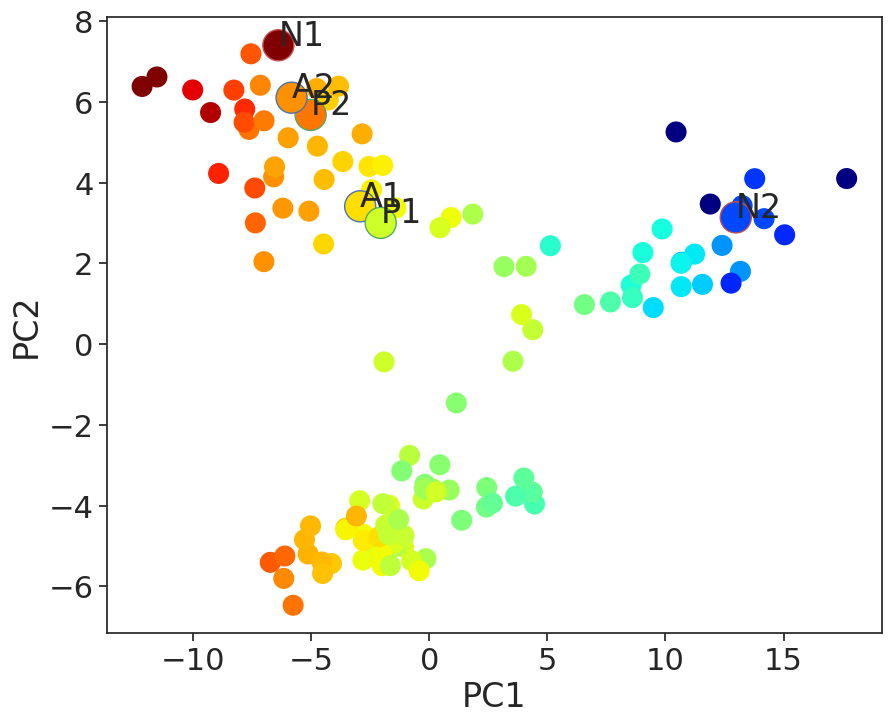

In [10]:
dfm = pd.read_csv('./results/chemical_space.csv', index_col='smiles')

a, p, n = "CHEMBL3661243", "CHEMBL3661245", "CHEMBL1357167" 
dfs['chemblid'] = dfs.index.map(dfm['Molecule ChEMBL ID'])
dfs['pred'] = predictions
dfs['true'] = dfs.index.map(dfm['pChEMBL'])

dfs['node_color'] = dfs.index.map(dfm['node_color'])
dfs['edgecolor'] = dfs.index.map(dfm['edgecolor'])
dfs['node_size'] = dfs.index.map(dfm['node_size'])
dfs['label'] = dfs.index.map(dfm['label'])

dfs1 = dfs[dfs.label == 'data']
dfs2 = dfs[dfs.label != 'data']

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(dfs1.dim1, dfs1.dim2, c = dfs1.node_color,s = dfs1.node_size,)
ax.scatter(dfs2.dim1, dfs2.dim2, c = dfs2.node_color, s = 500, edgecolors = dfs2.edgecolor)
for i in range(len(dfs2)):
    ts = dfs2.iloc[i]
    ax.text(ts.dim1, ts.dim2, ts.label)
    
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')